
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars_hw10.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
    
    """
    Not that it matters a lot but I usually put the dataframes in a list and concatenate them after coming out of loop.
    Someone at my previous organization said that it was more efficient but I did not check the efficiency benefit myself.
    """
#     filter_score = pd.concat([filter_score,new])
    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars_hw10.csv size is (96397, 1818)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
vars_hw10.csv                 variable     score
9                  Fraud  1.000000
793    card_zip3_total_7  0.695635
784    card_zip3_total_3  0.687836
547     card_zip_total_7  0.684517
802   card_zip3_total_14  0.681686
465   card_merch_total_7  0.681080
538     card_zip_total_3  0.677563
456   card_merch_total_3  0.675092
474  card_merch_total_14  0.674967
620   card_state_total_3  0.674228
556    card_zip_total_14  0.671828
629   card_state_total_7  0.669686
638  card_state_total_14  0.669055
775    card_zip3_total_1  0.666318
791      card_zip3_max_7  0.664943
811   card_zip3_total_30  0.660771
529     card_zip_total_1  0.660539
611   card_state_total_1  0.659137
483  card_merch_total_30  0.658364
800     card_zip3_max_14  0.658336
CPU times: user 36.7 s, sys: 5.45 s, total: 42.1 s
Wall time: 43.7 s


In [4]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [5]:
filter_score.head(30)

,variable,score
9,Fraud,1.000000
793,card_zip3_total_7,0.695635
784,card_zip3_total_3,0.687836
547,card_zip_total_7,0.684517
802,card_zip3_total_14,0.681686
465,card_merch_total_7,0.681080
538,card_zip_total_3,0.677563
456,card_merch_total_3,0.675092
474,card_merch_total_14,0.674967
620,card_state_total_3,0.674228


In [6]:
filter_score.tail(10)

,variable,score
1411,merchnum_zip_zip3_nunique,0.0
1407,merchnum_zip_Merch zip_nunique,0.0
7,Transtype,0.0
1416,merchnum_zip3_Merchnum_nunique,0.0
1332,card_merch_Merchnum_nunique,0.0
1423,merchnum_zip3_zip3_nunique,0.0
1331,card_merch_Cardnum_nunique,0.0
1326,Merch zip_zip3_nunique,0.0
1347,card_zip_Merch zip_nunique,0.0
1350,card_zip_zip3_nunique,0.0


In [7]:
filter_score.shape

(1818, 2)

In [8]:
filter_score.to_csv('filter_scores.csv',index=False)

In [12]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip3_total_3', 'card_zip_total_7', 'card_zip3_total_14', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_3', 'card_merch_total_14', 'card_state_total_3', 'card_zip_total_14', 'card_state_total_7', 'card_state_total_14', 'card_zip3_total_1', 'card_zip3_max_7', 'card_zip3_total_30', 'card_zip_total_1', 'card_state_total_1', 'card_merch_total_30', 'card_zip3_max_14', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_zip3_max_3', 'card_zip_total_30', 'card_merch_max_14', 'card_zip_max_30', 'card_merch_max_7', 'card_zip_max_3', 'card_merch_max_30', 'card_merch_total_45', 'card_zip_total_45', 'card_state_max_3', 'card_state_max_7', 'card_zip3_total_45', 'card_zip_total_60', 'card_merch_max_3', 'card_zip3_total_60', 'card_merch_max_45', 'card_zip_max_45', 'card_merch_total_60', 'card_zip3_max_30', 'card_merch_total_90', 'card_zip3_total_90', 'card_merch_max_60', 'card_zip_total_90', 'card_state_total_30', 'card_zip_max_60', 

In [13]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip3_total_3,card_zip_total_7,card_zip3_total_14,card_merch_total_7,card_zip_total_3,card_merch_total_3,card_merch_total_14,card_state_total_3,card_zip_total_14,...,merchnum_zip3_max_0,Merch state_actual/med_60,card_zip3_max_0,merchnum_state_total_1,card_zip_max_0,card_state_max_0,merchnum_zip_total_3,merchnum_zip3_total_1,Cardnum_total_3,card_zip_avg_30
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,174.20,1023.04,1023.04,1023.04,174.20,174.20,1023.04,174.20,1023.04,...,174.20,1.332517,174.20,174.20,174.20,174.20,3171.85,174.20,2069.29,341.013333
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.00,1.428571,250.00,250.00,250.00,250.00,250.00,250.00,2725.00,250.000000
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,...,53.88,0.276308,53.88,1116.55,53.88,53.88,3116.86,1116.55,76.85,38.425000
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,1269.00,7.511098,1269.00,1481.35,1269.00,1269.00,6512.60,1481.35,1617.06,1269.000000
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.38,1.466389,288.38,1189.68,288.38,288.38,1645.88,1189.68,1104.28,288.380000


In [14]:
df_keep.shape

(80983, 80)

In [15]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [16]:
Y = Y.values
Y_save = Y.copy()

In [17]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [18]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:03:01.623779


In [19]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [20]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [21]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [22]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [23]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.6s finished

[2022-04-13 02:11:16] Features: 1/20 -- score: 0.6223202352312216[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   18.2s finished

[2022-04-13 02:11:34] Features: 2/20 -- score: 0.6499198075380914[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   20.8s finished

[2022-04-13 02:11:55] Features: 3/20 -- score: 0.6716786955359529[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  77 out o

CPU times: user 7.01 s, sys: 4.48 s, total: 11.5 s
Wall time: 11min 17s


[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   49.8s finished

[2022-04-13 02:22:15] Features: 20/20 -- score: 0.6912322908313285

SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x7fc7e81cdd30>, verbose=2)

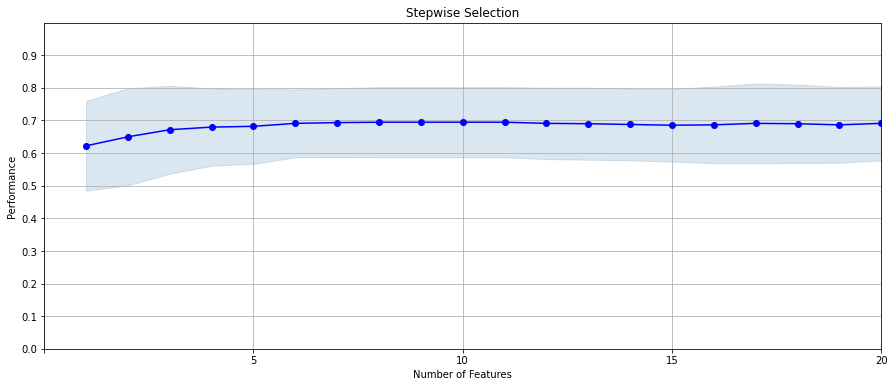

In [24]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [28]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [29]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [30]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(0,)","[0.42528735632183906, 0.6091954022988506, 0.74...",0.62232,"(card_zip3_total_7,)",0.102388,0.137857,0.045952,1.0,card_zip3_total_7
2,"(0, 73)","[0.40229885057471265, 0.6436781609195402, 0.74...",0.64992,"(card_zip3_total_7, merchnum_state_total_1)",0.110361,0.148591,0.04953,2.0,merchnum_state_total_1
3,"(0, 73, 78)","[0.4367816091954023, 0.6666666666666666, 0.758...",0.671679,"(card_zip3_total_7, merchnum_state_total_1, Ca...",0.100214,0.13493,0.044977,3.0,Cardnum_total_3
4,"(0, 35, 73, 78)","[0.41379310344827586, 0.6666666666666666, 0.75...",0.679725,"(card_zip3_total_7, card_merch_max_3, merchnum...",0.087955,0.118423,0.039474,4.0,card_merch_max_3
5,"(0, 23, 35, 73, 78)","[0.41379310344827586, 0.6551724137931034, 0.75...",0.682077,"(card_zip3_total_7, card_zip_total_30, card_me...",0.085376,0.114951,0.038317,5.0,card_zip_total_30
6,"(0, 23, 35, 38, 73, 78)","[0.4827586206896552, 0.6666666666666666, 0.747...",0.691206,"(card_zip3_total_7, card_zip_total_30, card_me...",0.077283,0.104054,0.034685,6.0,card_zip_max_45
7,"(0, 23, 35, 38, 64, 73, 78)","[0.4827586206896552, 0.6666666666666666, 0.747...",0.693518,"(card_zip3_total_7, card_zip_total_30, card_me...",0.078429,0.105598,0.035199,7.0,card_zip_total_0
8,"(0, 23, 28, 35, 38, 64, 73, 78)","[0.4827586206896552, 0.6666666666666666, 0.747...",0.694707,"(card_zip3_total_7, card_zip_total_30, card_me...",0.079937,0.107629,0.035876,8.0,card_merch_max_30
9,"(0, 23, 28, 35, 38, 56, 64, 73, 78)","[0.4827586206896552, 0.6666666666666666, 0.747...",0.694707,"(card_zip3_total_7, card_zip_total_30, card_me...",0.079937,0.107629,0.035876,9.0,card_zip3_total_0
10,"(0, 23, 28, 35, 38, 56, 59, 64, 73, 78)","[0.4827586206896552, 0.6666666666666666, 0.747...",0.694707,"(card_zip3_total_7, card_zip_total_30, card_me...",0.079937,0.107629,0.035876,10.0,card_merch_total_0


In [31]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [32]:
ordered_vars_FS['variable name']

1          card_zip3_total_7
2     merchnum_state_total_1
3            Cardnum_total_3
4           card_merch_max_3
5          card_zip_total_30
6            card_zip_max_45
7           card_zip_total_0
8          card_merch_max_30
9          card_zip3_total_0
10        card_merch_total_0
11        card_state_total_0
12       card_state_total_30
13       card_state_total_14
14            card_zip_max_3
15     merchnum_zip3_total_1
16        card_state_total_7
17        card_zip3_total_30
18       card_state_total_45
19          card_state_max_3
20          card_state_max_1
Name: variable name, dtype: object

In [33]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [34]:
vars_keep

1          card_zip3_total_7
2     merchnum_state_total_1
3            Cardnum_total_3
4           card_merch_max_3
5          card_zip_total_30
6            card_zip_max_45
7           card_zip_total_0
8          card_merch_max_30
9          card_zip3_total_0
10        card_merch_total_0
11        card_state_total_0
12       card_state_total_30
13       card_state_total_14
14            card_zip_max_3
15     merchnum_zip3_total_1
16        card_state_total_7
17        card_zip3_total_30
18       card_state_total_45
19          card_state_max_3
20          card_state_max_1
Name: variable name, dtype: object

In [35]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip3_total_7',
 'merchnum_state_total_1',
 'Cardnum_total_3',
 'card_merch_max_3',
 'card_zip_total_30',
 'card_zip_max_45',
 'card_zip_total_0',
 'card_merch_max_30',
 'card_zip3_total_0',
 'card_merch_total_0',
 'card_state_total_0',
 'card_state_total_30',
 'card_state_total_14',
 'card_zip_max_3',
 'merchnum_zip3_total_1',
 'card_state_total_7',
 'card_zip3_total_30',
 'card_state_total_45',
 'card_state_max_3',
 'card_state_max_1',
 'Recnum',
 'Fraud']

In [36]:
df = pd.read_csv(file_name)

In [37]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [38]:
df_keep.to_csv('vars_final_HW11.csv',index=False)

In [39]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:19:33.596296
